In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib as mpl
import matplotlib.pyplot as plt 
import pymssql
# import seaborn as sns
import sklearn
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM
from sklearn.metrics import mean_absolute_error
import seaborn as sns
from keras.preprocessing.sequence import TimeseriesGenerator

2022-10-25 19:54:03.354700: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-10-25 19:54:03.354768: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
def get_data():
    df=pd.DataFrame()
    try:
        con = pymssql.connect(user='ds_rcm',password = 'mtbc@123'
                     ,host='172.16.0.32',database='mis_db',autocommit = True)
    except Exception as e:
        print('unable to make connection',e)
    cur=con.cursor()

    query = """
    
SELECT CONVERT(date, CP.DATE_ENTRY) as Date, COUNT(DISTINCT C.CLAIM_NO) as Claims,
        SUM(CP.AMOUNT_PAID)'PAYMENTS'
        FROM PATIENT AS P
        JOIN CLAIMS AS C ON P.PATIENT_ACCOUNT=C.PATIENT_ACCOUNT

AND ISNULL(C.DELETED,0)=0
        AND ISNULL(P.DELETED,0)=0
        JOIN CLAIM_PAYMENTS AS CP ON C.CLAIM_NO=CP.CLAIM_NO
        AND ISNULL(CP.DELETED,0)=0
        JOIN PRACTICES AS PR ON PR.PRACTICE_CODE=P.PRACTICE_CODE
        AND PR.IS_ACTIVE=1 AND ISNULL(PR.IS_TEST_PRACTICE,0)=0
        AND ISNULL(PR.EXCLUDE_FROM_BILLING_REPORTS,0) = 0
        AND PR.EMR_NAME NOT IN ('CHARTS PRO','PM STANDALONE','TESTINGPRACTICE')
        AND PR.PRACTICE_CODE NOT LIKE '9090%' AND PR.PRAC_NAME NOT LIKE '%TEST%'
        WHERE CONVERT(date, CP.DATE_ENTRY) BETWEEN  CONVERT(date, '01-01-2019')
        AND CONVERT(date, '06-30-2022')
        GROUP BY CONVERT(date, CP.DATE_ENTRY)
        ORDER BY CONVERT(date, CP.DATE_ENTRY) ASC
        """
    try:
        cur.execute(query)
        df=pd.DataFrame(cur.fetchall(),columns=[x[0] for x in cur.description])
#         print(df)
#         df.columns=df.columns.str.upper()
        con.close()
    except:
        print('Error in reading data.....')
        con.close()
    return df

In [3]:
# claims = get_data()

In [4]:
# claims.to_csv('Payments_Data.csv')

In [5]:
# claims = pd.read_csv('Payments_Data.csv')

In [319]:
# claims = pd.read_csv('new_for_aaqil.csv')

In [4]:
claims.head()

,Date,Claims,PAYMENTS
0,2019-01-01,15589,696717.6800
1,2019-01-02,25068,1133132.8630
2,2019-01-03,30796,1560087.9600
3,2019-01-04,32438,1605829.1200
4,2019-01-05,9597,429901.3300


In [321]:
# print(claims.describe())

In [5]:
claims = claims[["Date", "PAYMENTS"]]

In [6]:
claims.PAYMENTS = claims.PAYMENTS.apply(int)

In [7]:
# print(claims.PAYMENTS.apply(int).describe())

In [8]:
claims.head()

,Date,PAYMENTS
0,2019-01-01,696717
1,2019-01-02,1133132
2,2019-01-03,1560087
3,2019-01-04,1605829
4,2019-01-05,429901


In [9]:
claims.isnull().sum()

Date        0
PAYMENTS    0
dtype: int64

In [10]:
len(claims)

1277

In [11]:
claims["Date"] = pd.to_datetime(claims["Date"])
claims = claims.sort_values('Date')
claims =claims.set_index("Date")

<AxesSubplot:xlabel='Date'>

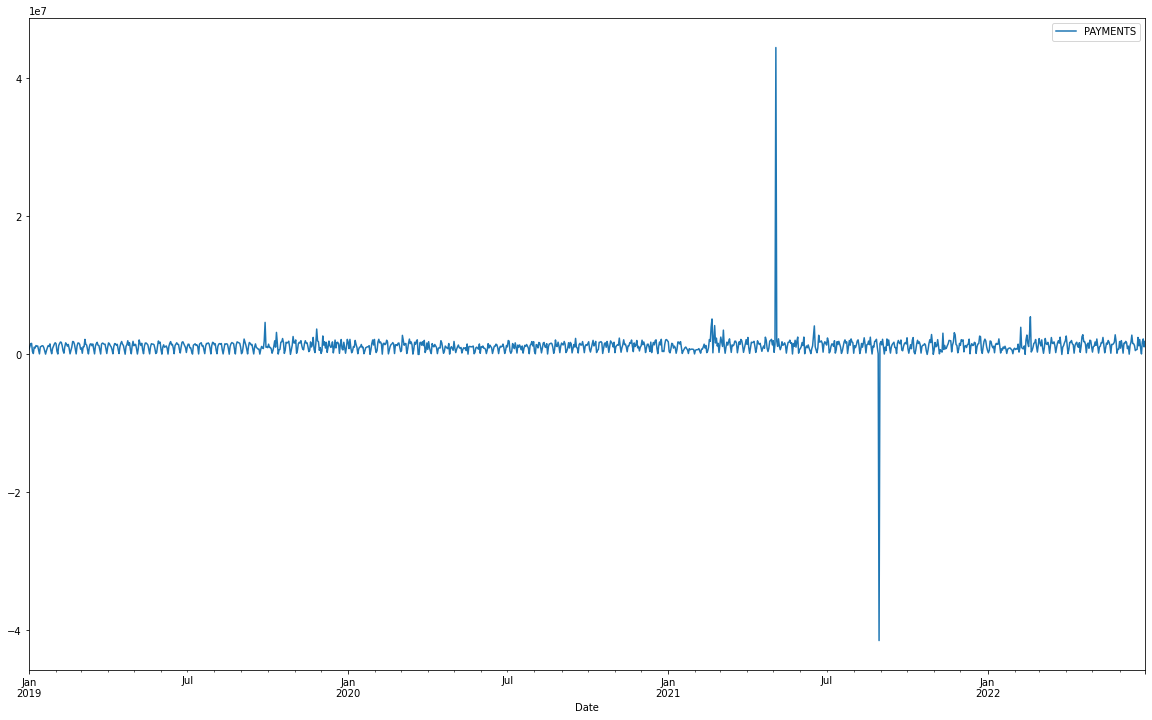

In [12]:
claims.plot(figsize=(20,12))

In [13]:
# check_p = claims.loc['2021-04-01':]
# check_p.PAYMENTS = check_p.PAYMENTS.apply(int)

In [14]:
# check_p.head(60)

In [15]:
# check = claims.loc['2021-08-01':]

In [16]:
# check.head(60)

In [17]:
from statsmodels.tsa.seasonal import seasonal_decompose

In [18]:
dec= seasonal_decompose(claims['PAYMENTS'])

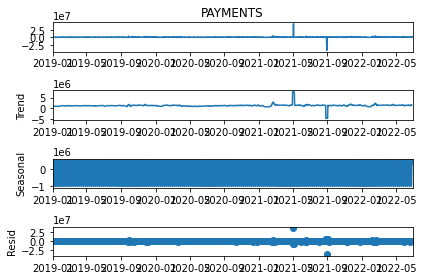

In [19]:
dec.plot();

In [20]:
train = claims.loc[:'2022-04-30']
test = claims.loc['2022-05-01':]


In [21]:
len(train)

1216

In [22]:
len(test)

61

In [23]:
scaler = MinMaxScaler()

In [24]:
scaler.fit(train)

MinMaxScaler()

In [25]:
scaled_train = scaler.transform(train)

In [26]:
scaled_test = scaler.transform(test) 

In [27]:
len(scaled_train)

1216

In [28]:
# define generator
n_input = 32
n_features = 1
generator = TimeseriesGenerator(scaled_train, scaled_train, length=n_input, batch_size=32
                               )

In [29]:
model = Sequential()

model.add(LSTM(units =128, activation='relu', return_sequences=True, input_shape = (n_input, n_features)))
model.add(Dropout(0.2))
model.add(LSTM(units =128, activation='relu', return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units =128, activation='relu', return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(units=1)) # Prediction of the next value
model.compile(optimizer='adam', loss='mse')

2022-10-25 19:55:12.545209: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-10-25 19:55:12.545496: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory
2022-10-25 19:55:12.545642: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory
2022-10-25 19:55:12.545781: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcufft.so.10'; dlerror: libcufft.so.10: cannot open shared object file: No such file or directory
2022-10-25 19:55:12.545917: W tensorflow/stream_executor/platform/default/dso_loader.cc:64

In [30]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 32, 128)           66560     
                                                                 
 dropout (Dropout)           (None, 32, 128)           0         
                                                                 
 lstm_1 (LSTM)               (None, 32, 128)           131584    
                                                                 
 dropout_1 (Dropout)         (None, 32, 128)           0         
                                                                 
 lstm_2 (LSTM)               (None, 128)               131584    
                                                                 
 dropout_2 (Dropout)         (None, 128)               0         
                                                                 
 dense (Dense)               (None, 1)                 1

In [31]:
# fit model
model.fit(generator,epochs=250)

Epoch 1/250
37/37 [==============================] - 9s 115ms/step - loss: 0.0429
Epoch 2/250
37/37 [==============================] - 4s 117ms/step - loss: 0.0025
Epoch 3/250
37/37 [==============================] - 4s 112ms/step - loss: 0.0021
Epoch 4/250
37/37 [==============================] - 4s 116ms/step - loss: 0.0021
Epoch 5/250
37/37 [==============================] - 4s 114ms/step - loss: 0.0020
Epoch 6/250
37/37 [==============================] - 4s 117ms/step - loss: 0.0018
Epoch 7/250
37/37 [==============================] - 4s 114ms/step - loss: 0.0018
Epoch 8/250
37/37 [==============================] - 4s 117ms/step - loss: 0.0018
Epoch 9/250
37/37 [==============================] - 4s 111ms/step - loss: 0.0018
Epoch 10/250
37/37 [==============================] - 4s 113ms/step - loss: 0.0016
Epoch 11/250
37/37 [==============================] - 4s 111ms/step - loss: 0.0015
Epoch 12/250
37/37 [==============================] - 4s 113ms/step - loss: 0.0016
Epoch 13/250


37/37 [==============================] - 4s 111ms/step - loss: 7.0430e-04
Epoch 99/250
37/37 [==============================] - 4s 112ms/step - loss: 6.6473e-04
Epoch 100/250
37/37 [==============================] - 4s 111ms/step - loss: 6.7233e-04
Epoch 101/250
37/37 [==============================] - 4s 116ms/step - loss: 6.4512e-04
Epoch 102/250
37/37 [==============================] - 4s 111ms/step - loss: 6.3992e-04
Epoch 103/250
37/37 [==============================] - 4s 114ms/step - loss: 6.7084e-04
Epoch 104/250
37/37 [==============================] - 4s 111ms/step - loss: 6.4138e-04
Epoch 105/250
37/37 [==============================] - 4s 115ms/step - loss: 6.4635e-04
Epoch 106/250
37/37 [==============================] - 4s 110ms/step - loss: 6.2889e-04
Epoch 107/250
37/37 [==============================] - 4s 111ms/step - loss: 6.5968e-04
Epoch 108/250
37/37 [==============================] - 4s 111ms/step - loss: 6.1682e-04
Epoch 109/250
37/37 [==========================

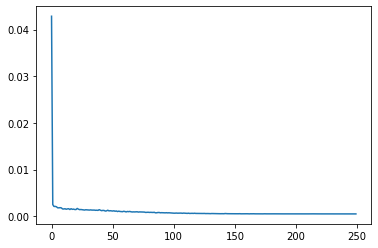

In [32]:
loss_per_epoch = model.history.history['loss']
plt.plot(range(len(loss_per_epoch)),loss_per_epoch)

In [33]:
first_eval_batch = scaled_train[-32:]

In [34]:
first_eval_batch = first_eval_batch.reshape((1,n_input,n_features))

In [35]:
model.predict(first_eval_batch)

1/1 [==============================] - 1s 655ms/step


array([[0.4990544]], dtype=float32)

In [36]:
#holding my predictions
test_predictions = []


# last n_input points from the training set
first_eval_batch = scaled_train[-n_input:]
# reshape this to the format RNN wants (same format as TimeseriesGeneration)
current_batch = first_eval_batch.reshape((1,n_input,n_features))

#how far into the future will I forecast?

for i in range(len(test)):
    
    # One timestep ahead of historical 12 points
    current_pred = model.predict(current_batch)[0]
    
    #store that prediction
    test_predictions.append(current_pred)
    
    # UPDATE current batch o include prediction
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]], axis= 1)

1/1 [==============================] - 0s 53ms/step


In [37]:
true_predictions = scaler.inverse_transform(test_predictions)

In [38]:
test['Predictions'] =true_predictions

/tmp/ipykernel_2792448/4217253912.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['Predictions'] =true_predictions


In [39]:
test.Predictions = test.Predictions.apply(int)

/home/aaqil/aaqil_env/lib/python3.8/site-packages/pandas/core/generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [40]:
test.head()

,PAYMENTS,Predictions
Date,,
2022-05-01,342668,1428230
2022-05-02,1146876,1428230
2022-05-03,1192750,1428227
2022-05-04,1808644,1428225
2022-05-05,1315464,1428222


<AxesSubplot:xlabel='Date'>

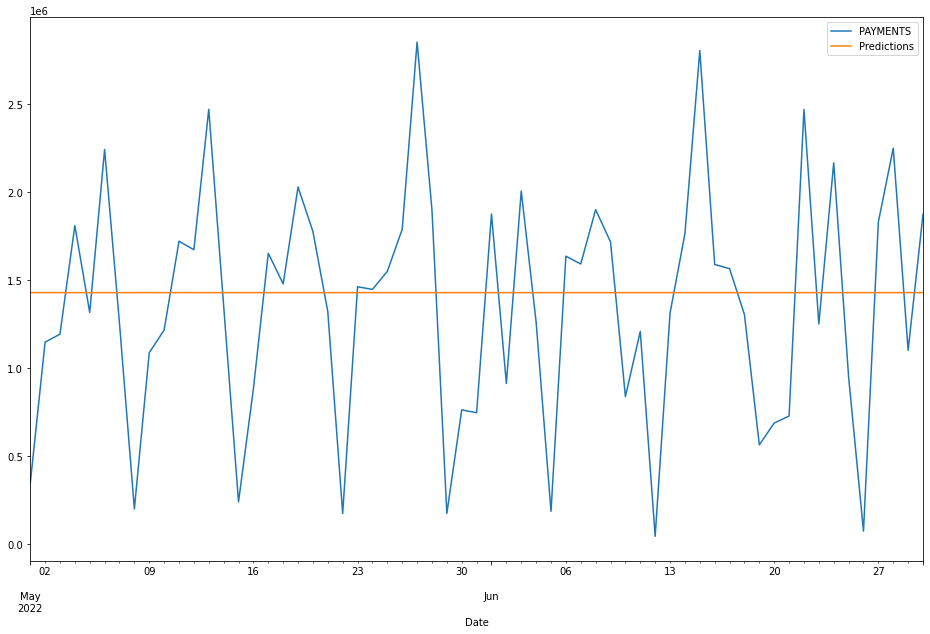

In [41]:
test.plot(figsize=(16,10))

In [42]:
from sklearn.metrics import mean_squared_error
from math import sqrt
rmse=sqrt(mean_squared_error(test['PAYMENTS'],test['Predictions']))
print(rmse)

671488.2447084286


In [43]:
def mean_absolute_percentage_error(y_true, y_pred): 
    """Calculates MAPE given y_true and y_pred"""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [44]:
mean_absolute_percentage_error(test['PAYMENTS'],test['Predictions'])

164.36777577443976